In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Models & metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Paths
BASE_DIR = Path().resolve().parents[1]
file_PATH_arctic = BASE_DIR / "data" / "processed" / "final_arctic.csv" 

# Load data
df = pd.read_csv(file_PATH_arctic)
df = df.sort_values(["year", "month"])

# Features & target
X = df.drop(columns=["sia_million_km2"])
y = df["sia_million_km2"]

In [4]:
# Evaluation Metrics
def eval_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Performance:")
    print(f" MAE : {mae:.4f}")
    print(f" MSE : {mse:.4f}")
    print(f" RMSE: {rmse:.4f}")
    print(f" MAPE: {mape:.2f}%")
    print(f" R²  : {r2:.4f}")

    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape, "R2": r2}

In [6]:
# === Prepare exogenous variables ===
df["date"] = pd.to_datetime(df[["year", "month"]].assign(day=1))
X_exog = X.drop(columns=["year", "month"]).copy()
y_sarimax = y.copy()

# Clean NaN / Inf
X_exog = X_exog.replace([np.inf, -np.inf], np.nan)
X_exog = X_exog.fillna(method="ffill").fillna(method="bfill")

# === Train/Test Split (70:30) ===
train_size = int(len(df) * 0.7)
train_exog, test_exog = X_exog.iloc[:train_size], X_exog.iloc[train_size:]
train_y, test_y = y_sarimax.iloc[:train_size], y_sarimax.iloc[train_size:]

C:\Users\Sathvik\AppData\Local\Temp\ipykernel_1560\3857220757.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_exog = X_exog.fillna(method="ffill").fillna(method="bfill")


In [7]:
# === SARIMAX ===
model_sarimax = SARIMAX(train_y, exog=train_exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
res_sarimax = model_sarimax.fit(disp=False)
sarimax_preds = res_sarimax.predict(start=len(train_y), end=len(df)-1, exog=test_exog)
metrics_sarimax = eval_metrics(test_y, sarimax_preds, "SARIMAX")

C:\Users\Sathvik\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



SARIMAX Performance:
 MAE : 0.1360
 MSE : 0.0265
 RMSE: 0.1628
 MAPE: 1.85%
 R²  : 0.9978


In [8]:
# === Random Forest ===
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(train_exog, train_y)
rf_preds = rf.predict(test_exog)
metrics_rf = eval_metrics(test_y, rf_preds, "Random Forest")


Random Forest Performance:
 MAE : 0.1340
 MSE : 0.0320
 RMSE: 0.1788
 MAPE: 1.96%
 R²  : 0.9973


In [9]:
# === Linear Regression ===
lr = LinearRegression()
lr.fit(train_exog, train_y)
lr_preds = lr.predict(test_exog)
metrics_lr = eval_metrics(test_y, lr_preds, "Linear Regression")


Linear Regression Performance:
 MAE : 0.0712
 MSE : 0.0081
 RMSE: 0.0901
 MAPE: 0.94%
 R²  : 0.9993


In [10]:
# === LSTM ===
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_exog)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

lookback = 12
X_seq, y_seq = [], []
for i in range(lookback, len(X_scaled)):
    X_seq.append(X_scaled[i-lookback:i])
    y_seq.append(y_scaled[i])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

train_size_lstm = int(len(X_seq) * 0.7)
X_train_lstm, X_test_lstm = X_seq[:train_size_lstm], X_seq[train_size_lstm:]
y_train_lstm, y_test_lstm = y_seq[:train_size_lstm], y_seq[train_size_lstm:]

model_lstm = Sequential([
    LSTM(64, activation='relu', input_shape=(lookback, X_seq.shape[2])),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=16, verbose=0)

lstm_preds_scaled = model_lstm.predict(X_test_lstm)
lstm_preds = scaler_y.inverse_transform(lstm_preds_scaled)
y_test_lstm_orig = scaler_y.inverse_transform(y_test_lstm)

metrics_lstm = eval_metrics(y_test_lstm_orig, lstm_preds, "LSTM")


C:\Users\Sathvik\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 

LSTM Performance:
 MAE : 0.3061
 MSE : 0.1609
 RMSE: 0.4012
 MAPE: 4.20%
 R²  : 0.9865


In [11]:
# === Summary Table ===
summary_df = pd.DataFrame({
    "SARIMAX": metrics_sarimax,
    "Random Forest": metrics_rf,
    "Linear Regression": metrics_lr,
    "LSTM": metrics_lstm
})

print("\n=== Model Comparison ===")
print(summary_df)


=== Model Comparison ===
       SARIMAX  Random Forest  Linear Regression      LSTM
MAE   0.135999       0.133988           0.071213  0.306124
MSE   0.026494       0.031979           0.008124  0.160936
RMSE  0.162770       0.178827           0.090135  0.401168
MAPE  1.849174       1.955212           0.943180  4.198069
R2    0.997776       0.997316           0.999318  0.986544


In [17]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

# === Paths & Load Data ===
BASE_DIR = Path().resolve().parents[1]
file_PATH_arctic = BASE_DIR / "data" / "processed" / "final_arctic.csv"

df = pd.read_csv(file_PATH_arctic)
df = df.sort_values(["year", "month"])

X = df.drop(columns=["sia_million_km2"])
y = df["sia_million_km2"]

df["date"] = pd.to_datetime(df[["year", "month"]].assign(day=1))
X_exog = X.drop(columns=["year", "month"]).replace([np.inf, -np.inf], np.nan).fillna(method="ffill").fillna(method="bfill")


C:\Users\Sathvik\AppData\Local\Temp\ipykernel_1560\3082022440.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_exog = X.drop(columns=["year", "month"]).replace([np.inf, -np.inf], np.nan).fillna(method="ffill").fillna(method="bfill")


In [18]:
def eval_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape, "R2": r2}


In [19]:
# === Walk-forward validation ===
def walk_forward_validation(X_exog, y, train_ratio=0.7, step=12):
    n_total = len(y)
    train_size = int(n_total * train_ratio)
    metrics_all = {"SARIMAX": [], "Random Forest": [], "Linear Regression": [], "LSTM": []}

    for end_train in range(train_size, n_total - step + 1, step):
        # Split
        train_exog = X_exog.iloc[:end_train]
        test_exog = X_exog.iloc[end_train:end_train + step]
        train_y = y.iloc[:end_train]
        test_y = y.iloc[end_train:end_train + step]

        # --- SARIMAX ---
        sarimax_model = SARIMAX(train_y, exog=train_exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarimax_res = sarimax_model.fit(disp=False)
        sarimax_preds = sarimax_res.predict(start=end_train, end=end_train + step - 1, exog=test_exog)
        metrics_all["SARIMAX"].append(eval_metrics(test_y, sarimax_preds))

        # --- Random Forest ---
        scaler_rf = MinMaxScaler().fit(train_exog)
        train_rf_scaled = scaler_rf.transform(train_exog)
        test_rf_scaled = scaler_rf.transform(test_exog)

        rf = RandomForestRegressor(n_estimators=200, random_state=42)
        rf.fit(train_rf_scaled, train_y)
        rf_preds = rf.predict(test_rf_scaled)
        metrics_all["Random Forest"].append(eval_metrics(test_y, rf_preds))

        # --- Linear Regression ---
        lr = LinearRegression()
        lr.fit(train_rf_scaled, train_y)
        lr_preds = lr.predict(test_rf_scaled)
        metrics_all["Linear Regression"].append(eval_metrics(test_y, lr_preds))

        # --- LSTM ---
        scaler_X = MinMaxScaler().fit(train_exog)
        scaler_y = MinMaxScaler().fit(train_y.values.reshape(-1, 1))
        X_scaled = scaler_X.transform(X_exog)
        y_scaled = scaler_y.transform(y.values.reshape(-1, 1))

        lookback = 12
        X_seq, y_seq = [], []
        for i in range(lookback, end_train + step):
            X_seq.append(X_scaled[i-lookback:i])
            y_seq.append(y_scaled[i])
        X_seq, y_seq = np.array(X_seq), np.array(y_seq)

        train_size_seq = end_train - lookback
        X_train_lstm, X_test_lstm = X_seq[:train_size_seq], X_seq[train_size_seq:]
        y_train_lstm, y_test_lstm = y_seq[:train_size_seq], y_seq[train_size_seq:]

        tf.keras.backend.clear_session()
        lstm_model = Sequential([
            LSTM(64, activation='relu', input_shape=(lookback, X_seq.shape[2])),
            Dense(1)
        ])
        lstm_model.compile(optimizer='adam', loss='mse')
        lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=16, verbose=0)

        lstm_preds_scaled = lstm_model.predict(X_test_lstm, verbose=0)
        lstm_preds = scaler_y.inverse_transform(lstm_preds_scaled)
        y_test_lstm_orig = scaler_y.inverse_transform(y_test_lstm)
        metrics_all["LSTM"].append(eval_metrics(y_test_lstm_orig, lstm_preds))

    # Average metrics
    avg_metrics = {}
    for model in metrics_all:
        df_metrics = pd.DataFrame(metrics_all[model])
        avg_metrics[model] = df_metrics.mean().to_dict()
    return pd.DataFrame(avg_metrics)

In [20]:
# === Run walk-forward validation ===
summary_df = walk_forward_validation(X_exog, y, train_ratio=0.7, step=12)

print("\n=== Average Model Performance (Walk-Forward) ===")
print(summary_df)

C:\Users\Sathvik\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Sathvik\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\Sathvik\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Sathvik\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\Sathvik\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood 

C:\Users\Sathvik\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Sathvik\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


C:\Users\Sathvik\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Sathvik\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\Sathvik\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Sathvik\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  wa


=== Average Model Performance (Walk-Forward) ===
       SARIMAX  Random Forest  Linear Regression      LSTM
MAE   0.101443       0.105840           0.063067  0.416414
MSE   0.019017       0.022274           0.006490  0.277206
RMSE  0.117613       0.138356           0.078743  0.500854
MAPE  1.350365       1.599279           0.831717  6.076081
R2    0.998372       0.998176           0.999440  0.977102


C:\Users\Sathvik\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Evaluation Metrics:
MAE  : 0.0766
RMSE : 0.1199
R²   : 0.9988


C:\Users\Sathvik\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Sathvik\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


First ice-free September predicted in: 2054


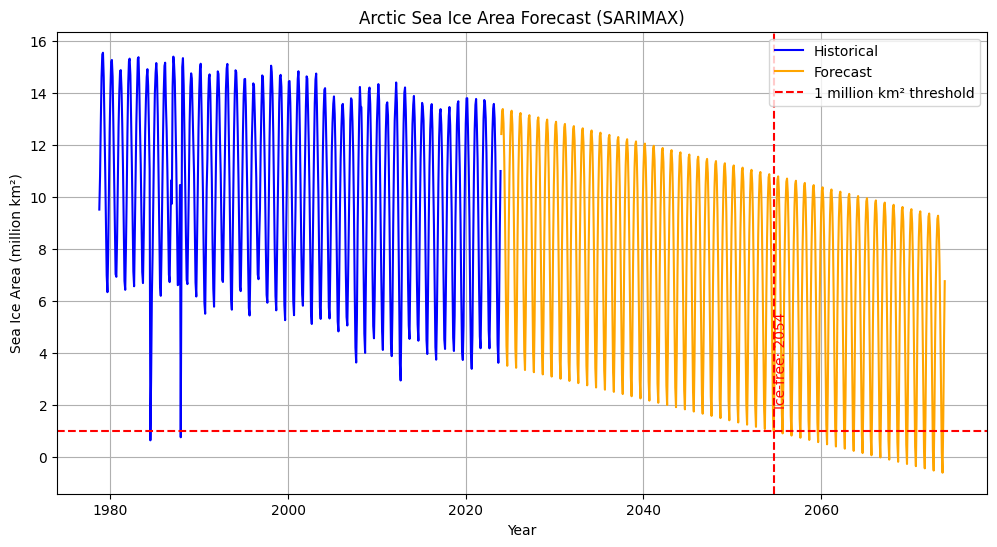

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX

# === Paths & Load Data ===
BASE_DIR = Path().resolve().parents[1]
file_PATH_arctic = BASE_DIR / "data" / "processed" / "final_arctic.csv"

df = pd.read_csv(file_PATH_arctic)
df = df.sort_values(["year", "month"])
df["date"] = pd.to_datetime(df[["year", "month"]].assign(day=1))

y = df["sia_million_km2"]
X_exog = df.drop(columns=["sia_million_km2", "year", "month", "date"]) \
           .replace([np.inf, -np.inf], np.nan) \
           .ffill().bfill()

# === Split data (80% train, 20% test) ===
split_index = int(len(df) * 0.8)
train_y, test_y = y.iloc[:split_index], y.iloc[split_index:]
train_X, test_X = X_exog.iloc[:split_index], X_exog.iloc[split_index:]

# === Train SARIMAX ===
sarimax_model = SARIMAX(train_y, exog=train_X, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_res = sarimax_model.fit(disp=False)

# === Predict on test set ===
preds = sarimax_res.get_forecast(steps=len(test_y), exog=test_X).predicted_mean

# === Metrics ===
mae = mean_absolute_error(test_y, preds)
rmse = mean_squared_error(test_y, preds) ** 0.5
r2 = r2_score(test_y, preds)

print("Model Evaluation Metrics:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# === Retrain on full data for future forecast ===
sarimax_full = SARIMAX(y, exog=X_exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_full_res = sarimax_full.fit(disp=False)

# === Forecast forward ===
n_years_forecast = 50
future_dates = pd.date_range(start=df["date"].iloc[-1] + pd.offsets.MonthBegin(),
                             periods=n_years_forecast * 12, freq="MS")

future_exog = pd.DataFrame(
    np.tile(X_exog.iloc[-12:].values, (n_years_forecast, 1)),
    columns=X_exog.columns
)

forecast = sarimax_full_res.get_forecast(steps=n_years_forecast * 12, exog=future_exog)
forecast_mean = forecast.predicted_mean

# === Detect first ice-free September (< 1 million km²) ===
future_forecast_df = pd.DataFrame({"date": future_dates, "value": forecast_mean})
future_forecast_df["month"] = future_forecast_df["date"].dt.month
future_forecast_df["year"] = future_forecast_df["date"].dt.year
ice_free_year = future_forecast_df[(future_forecast_df["month"] == 9) & (future_forecast_df["value"] < 1)].head(1)

if not ice_free_year.empty:
    ice_free_year_val = int(ice_free_year["year"].iloc[0])
    print(f"First ice-free September predicted in: {ice_free_year_val}")
else:
    print("No ice-free September within forecast horizon.")

# === Plot ===
plt.figure(figsize=(12, 6))
plt.plot(df["date"], y, label="Historical", color="blue")
plt.plot(future_dates, forecast_mean, label="Forecast", color="orange")
plt.axhline(1, color="red", linestyle="--", label="1 million km² threshold")

if not ice_free_year.empty:
    plt.axvline(pd.to_datetime(f"{ice_free_year_val}-09-01"), color="red", linestyle="--")
    plt.text(pd.to_datetime(f"{ice_free_year_val}-09-01"), 2,
             f"Ice-free: {ice_free_year_val}", rotation=90, color="red")

plt.title("Arctic Sea Ice Area Forecast (SARIMAX)")
plt.ylabel("Sea Ice Area (million km²)")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
plt.show()


All DATA Train

Average Sea Ice Area in 2024 (forecast): 9.366 million km²

Monthly Forecast for 2024:
      date  value
2024-01-01 12.431
2024-02-01 13.279
2024-03-01 13.464
2024-04-01 12.770
2024-05-01 11.603
2024-06-01  9.380
2024-07-01  6.613
2024-08-01  4.205
2024-09-01  3.534
2024-10-01  5.510
2024-11-01  8.686
2024-12-01 10.918

First ice-free month predicted: September 2047


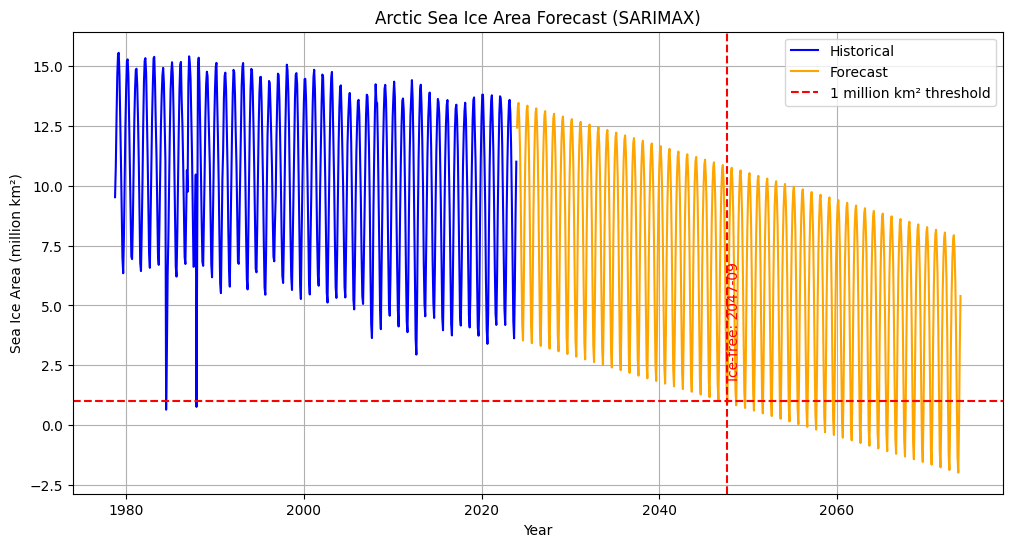

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX

# === Load Data ===
BASE_DIR = Path().resolve().parents[1]
file_PATH_arctic = BASE_DIR / "data" / "processed" / "final_arctic.csv"

df = pd.read_csv(file_PATH_arctic)
df = df.sort_values(["year", "month"])
df["date"] = pd.to_datetime(df[["year", "month"]].assign(day=1))

y = df["sia_million_km2"]
X_exog = df.drop(columns=["sia_million_km2", "year", "month", "date"]) \
           .replace([np.inf, -np.inf], np.nan).ffill().bfill()

# === Train SARIMAX on ALL data ===
sarimax_model = SARIMAX(y, exog=X_exog, order=(1, 1, 1), seasonal_order=(1, 1, 1,2))
sarimax_res = sarimax_model.fit(disp=False)

# === Forecast future ===
n_years_forecast = 50
future_dates = pd.date_range(start=df["date"].iloc[-1] + pd.offsets.MonthBegin(),
                             periods=n_years_forecast * 12, freq="MS")

future_exog = pd.DataFrame(
    np.tile(X_exog.iloc[-12:].values, (n_years_forecast, 1)),
    columns=X_exog.columns
)

forecast = sarimax_res.get_forecast(steps=n_years_forecast * 12, exog=future_exog)
forecast_mean = forecast.predicted_mean

forecast_df = pd.DataFrame({"date": future_dates, "value": forecast_mean})
forecast_df["year"] = forecast_df["date"].dt.year
forecast_df["month"] = forecast_df["date"].dt.month

# === 1) Average for 2024 ===
avg_2024 = forecast_df.loc[forecast_df["year"] == 2024, "value"].mean()
print(f"Average Sea Ice Area in 2024 (forecast): {avg_2024:.3f} million km²")

# === 2) Monthly values for 2024 ===
monthly_2024 = forecast_df[forecast_df["year"] == 2024][["date", "value"]]
print("\nMonthly Forecast for 2024:")
print(monthly_2024.to_string(index=False, formatters={"value": "{:.3f}".format}))

# === First ice-free month (< 1 million km²) ===
ice_free = forecast_df[forecast_df["value"] < 1].head(1)
if not ice_free.empty:
    first_ice_free_date = ice_free["date"].iloc[0]
    print(f"\nFirst ice-free month predicted: {first_ice_free_date.strftime('%B %Y')}")
else:
    print("\nNo ice-free month within forecast horizon.")

# === Plot historical + forecast ===
plt.figure(figsize=(12, 6))
plt.plot(df["date"], y, label="Historical", color="blue")
plt.plot(forecast_df["date"], forecast_df["value"], label="Forecast", color="orange")
plt.axhline(1, color="red", linestyle="--", label="1 million km² threshold")

if not ice_free.empty:
    plt.axvline(first_ice_free_date, color="red", linestyle="--")
    plt.text(first_ice_free_date, 2,
             f"Ice-free: {first_ice_free_date.strftime('%Y-%m')}",
             rotation=90, color="red")

plt.title("Arctic Sea Ice Area Forecast (SARIMAX)")
plt.ylabel("Sea Ice Area (million km²)")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
plt.show()


phase 1

Out-of-Sample Model Evaluation Metrics:
MAE  : 0.0594
RMSE : 0.0755
R²   : 0.9995
MAPE : 0.74%


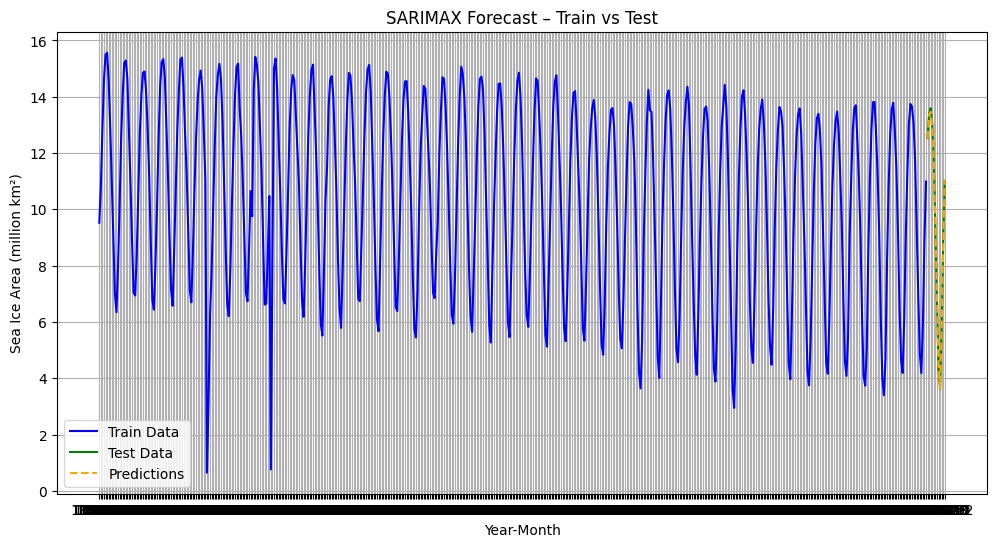


Average Sea Ice Area in 2024 (forecast): 9.355 million km²

Monthly Forecast for 2024:
        date      value  year  month
543  2024-01  12.432745  2024      1
544  2024-02  13.286465  2024      2
545  2024-03  13.394087  2024      3
546  2024-04  12.850752  2024      4
547  2024-05  11.511584  2024      5
548  2024-06   9.237625  2024      6
549  2024-07   6.697305  2024      7
550  2024-08   4.267218  2024      8
551  2024-09   3.510970  2024      9
552  2024-10   5.519793  2024     10
553  2024-11   8.665253  2024     11
554  2024-12  10.882491  2024     12

First ice-free September predicted in: 2054-09


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX

# === Load Data ===
BASE_DIR = Path().resolve().parents[1]
file_PATH_arctic = BASE_DIR / "data" / "processed" / "final_arctic.csv"

df = pd.read_csv(file_PATH_arctic)
df = df.sort_values(["year", "month"])

# Use PeriodIndex for monthly data (no artificial day=1)
df["date"] = pd.PeriodIndex(year=df["year"], month=df["month"], freq="M")

# Target & exogenous features
y = df["sia_million_km2"]
X_exog = df.drop(columns=["sia_million_km2", "year", "month", "date"]) \
           .replace([np.inf, -np.inf], np.nan).ffill().bfill()

# === Train/Test Split ===
split_date = pd.Period("2023-01", freq="M")
train_mask = df["date"] < split_date
test_mask = df["date"] >= split_date

train_y, test_y = y[train_mask], y[test_mask]
train_exog, test_exog = X_exog[train_mask], X_exog[test_mask]

# === Train SARIMAX ===
sarimax_model = SARIMAX(train_y, exog=train_exog,
                        order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_res = sarimax_model.fit(disp=False)

# === Forecast on Test Set ===
preds = sarimax_res.get_forecast(steps=len(test_y), exog=test_exog).predicted_mean

# === Metrics ===
mae = mean_absolute_error(test_y, preds)
rmse = mean_squared_error(test_y, preds) ** 0.5
r2 = r2_score(test_y, preds)
mape = np.mean(np.abs((test_y - preds) / test_y)) * 100

print("Out-of-Sample Model Evaluation Metrics:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")
print(f"MAPE : {mape:.2f}%")

# === Plot Training vs Testing ===
plt.figure(figsize=(12, 6))
plt.plot(df["date"][train_mask].astype(str), train_y, label="Train Data", color="blue")
plt.plot(df["date"][test_mask].astype(str), test_y, label="Test Data", color="green")
plt.plot(df["date"][test_mask].astype(str), preds, label="Predictions", color="orange", linestyle="--")
plt.title("SARIMAX Forecast – Train vs Test")
plt.ylabel("Sea Ice Area (million km²)")
plt.xlabel("Year-Month")
plt.legend()
plt.grid(True)
plt.show()

# === Retrain on full data for future forecast ===
sarimax_full = SARIMAX(y, exog=X_exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_full_res = sarimax_full.fit(disp=False)

# === Forecast far ahead (no fixed limit) ===
n_years_forecast = 50
future_periods = pd.period_range(start=df["date"].iloc[-1] + 1, periods=n_years_forecast * 12, freq="M")
future_exog = pd.DataFrame(
    np.tile(X_exog.iloc[-12:].values, (n_years_forecast, 1)),
    columns=X_exog.columns
)
forecast = sarimax_full_res.get_forecast(steps=len(future_periods), exog=future_exog)
forecast_mean = forecast.predicted_mean

forecast_df = pd.DataFrame({"date": future_periods, "value": forecast_mean})
forecast_df["year"] = forecast_df["date"].dt.year
forecast_df["month"] = forecast_df["date"].dt.month

# === 2024 Predictions ===
avg_2024 = forecast_df.loc[forecast_df["year"] == 2024, "value"].mean()
print(f"\nAverage Sea Ice Area in 2024 (forecast): {avg_2024:.3f} million km²")

monthly_2024 = forecast_df[forecast_df["year"] == 2024]
print("\nMonthly Forecast for 2024:")
print(monthly_2024)

# === Detect first ice-free September (< 1 million km²) ===
ice_free_year = forecast_df[(forecast_df["month"] == 9) & (forecast_df["value"] < 1)].head(1)
if not ice_free_year.empty:
    print(f"\nFirst ice-free September predicted in: {ice_free_year.iloc[0]['date']}")
else:
    print("\nNo ice-free September within forecast horizon.")


Highly correlated variables to drop (>0.95): ['uvb', 'istl1', 'istl2', 'istl3', 'istl4', 'skt', 'tsn']
Shape before: (543, 16), after: (543, 9)

Average Sea Ice Area in 2024 (forecast): 9.483 million km²

Monthly Forecast for 2024:
        date      value   lower_ci   upper_ci  year  month
543  2024-01  12.494868  12.281026  12.708711  2024      1
544  2024-02  13.393738  13.128105  13.659370  2024      2
545  2024-03  13.507192  13.215901  13.798482  2024      3
546  2024-04  12.973272  12.667248  13.279296  2024      4
547  2024-05  11.653528  11.338108  11.968947  2024      5
548  2024-06   9.376067   9.054090   9.698045  2024      6
549  2024-07   6.821687   6.494756   7.148617  2024      7
550  2024-08   4.400324   4.069391   4.731257  2024      8
551  2024-09   3.666490   3.332141   4.000840  2024      9
552  2024-10   5.673922   5.336528   6.011315  2024     10
553  2024-11   8.820101   8.479908   9.160294  2024     11
554  2024-12  11.019085  10.676256  11.361914  2024     12



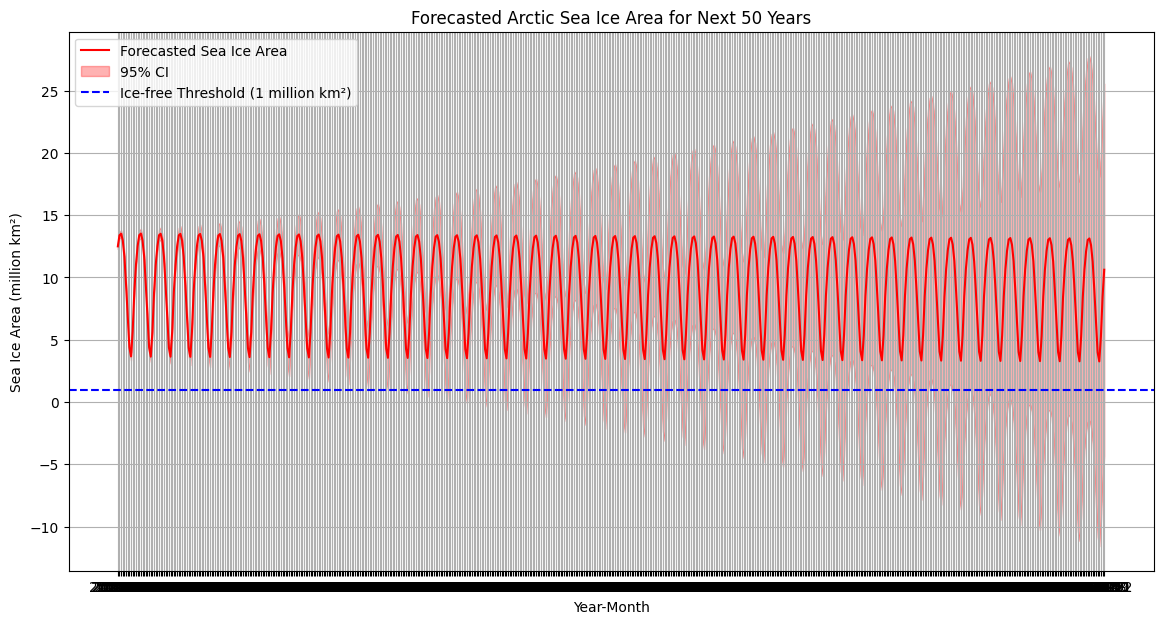

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

warnings.filterwarnings("ignore")

# === Load Data ===
BASE_DIR = Path().resolve().parents[1]
file_PATH_arctic = BASE_DIR / "data" / "processed" / "final_arctic.csv"

df = pd.read_csv(file_PATH_arctic)
df = df.sort_values(["year", "month"])

# Use PeriodIndex for monthly data
df["date"] = pd.PeriodIndex(year=df["year"], month=df["month"], freq="M")

# Target & initial exogenous features
y = df["sia_million_km2"]
predictors = df.drop(columns=["sia_million_km2", "year", "month", "date"]) \
               .replace([np.inf, -np.inf], np.nan).ffill().bfill()

# === Drop highly correlated predictors ===
corr_matrix = predictors.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

threshold = 0.95
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print(f"Highly correlated variables to drop (>{threshold}): {to_drop}")
X_exog = predictors.drop(columns=to_drop)

print(f"Shape before: {predictors.shape}, after: {X_exog.shape}")

# === Train SARIMAX on full dataset ===
sarimax_full = SARIMAX(y, exog=X_exog,
                       order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarimax_full_res = sarimax_full.fit(disp=False)

# === Forecast far ahead ===
n_years_forecast = 50
future_periods = pd.period_range(start=df["date"].iloc[-1] + 1,
                                 periods=n_years_forecast * 12, freq="M")

# Repeat last 12 months of exog variables for future forecast
future_exog = pd.DataFrame(
    np.tile(X_exog.iloc[-12:].values, (n_years_forecast, 1)),
    columns=X_exog.columns
)

future_forecast = sarimax_full_res.get_forecast(steps=len(future_periods), exog=future_exog)
forecast_mean = future_forecast.predicted_mean
forecast_ci = future_forecast.conf_int()

forecast_df = pd.DataFrame({
    "date": future_periods,
    "value": forecast_mean,
    "lower_ci": forecast_ci.iloc[:, 0].values,
    "upper_ci": forecast_ci.iloc[:, 1].values
})
forecast_df["year"] = forecast_df["date"].dt.year
forecast_df["month"] = forecast_df["date"].dt.month

# === 2024 Predictions ===
avg_2024 = forecast_df.loc[forecast_df["year"] == 2024, "value"].mean()
print(f"\nAverage Sea Ice Area in 2024 (forecast): {avg_2024:.3f} million km²")

monthly_2024 = forecast_df[forecast_df["year"] == 2024]
print("\nMonthly Forecast for 2024:")
print(monthly_2024)

# === Detect first ice-free September (< 1 million km²) ===
ice_free_year = forecast_df[(forecast_df["month"] == 9) & (forecast_df["value"] < 1)].head(1)
if not ice_free_year.empty:
    print(f"\nFirst ice-free September predicted in: {ice_free_year.iloc[0]['date']}")
else:
    print("\nNo ice-free September within forecast horizon.")

# === Plot forecast ===
plt.figure(figsize=(14, 7))
plt.plot(forecast_df["date"].astype(str), forecast_df["value"], label="Forecasted Sea Ice Area", color="red")
plt.fill_between(forecast_df["date"].astype(str), forecast_df["lower_ci"], forecast_df["upper_ci"],
                 color="red", alpha=0.3, label="95% CI")
plt.axhline(1, color="blue", linestyle="--", label="Ice-free Threshold (1 million km²)")
plt.title(f"Forecasted Arctic Sea Ice Area for Next {n_years_forecast} Years")
plt.ylabel("Sea Ice Area (million km²)")
plt.xlabel("Year-Month")
plt.legend()
plt.grid(True)
plt.show()



SARIMAX

C:\Users\Sathvik\AppData\Local\Temp\ipykernel_21260\771312172.py:14: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  df["date"] = pd.PeriodIndex(year=df["year"], month=df["month"], freq="M")
C:\Users\Sathvik\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Average Sea Ice Area in 2024 (forecast): 9.464 million km²

Monthly Forecast for 2024:
          date      value  year  month
543 2024-01-01  12.480897  2024      1
544 2024-02-01  13.371857  2024      2
545 2024-03-01  13.495413  2024      3
546 2024-04-01  12.960133  2024      4
547 2024-05-01  11.626266  2024      5
548 2024-06-01   9.355640  2024      6
549 2024-07-01   6.817391  2024      7
550 2024-08-01   4.388578  2024      8
551 2024-09-01   3.633337  2024      9
552 2024-10-01   5.643941  2024     10
553 2024-11-01   8.789676  2024     11
554 2024-12-01  11.005983  2024     12

No ice-free September within forecast horizon.


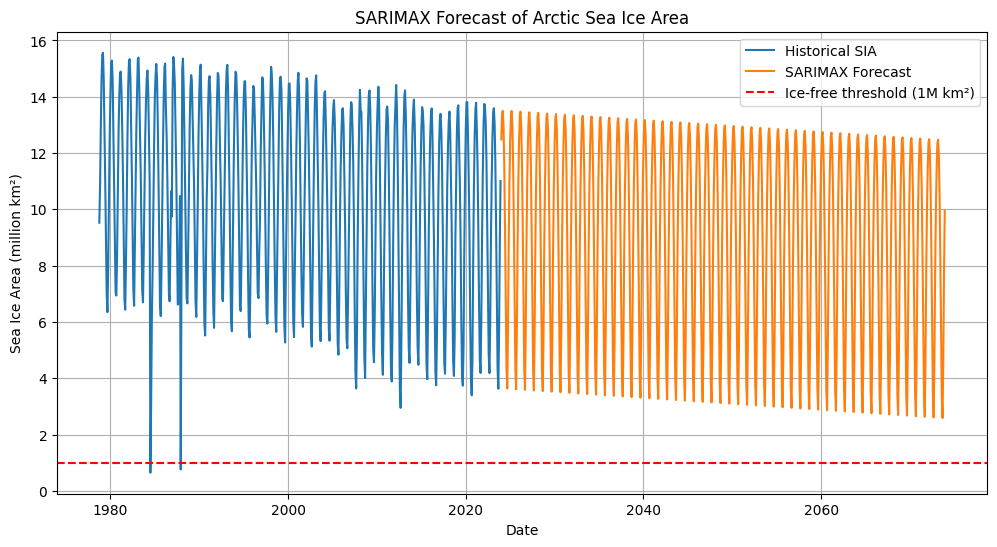

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX

# === Load Data ===
BASE_DIR = Path().resolve().parents[1]
file_PATH_arctic = BASE_DIR / "data" / "processed" / "final_arctic.csv"
df = pd.read_csv(file_PATH_arctic)
df = df.sort_values(["year", "month"])

# Use PeriodIndex for monthly data (no artificial day=1)
df["date"] = pd.PeriodIndex(year=df["year"], month=df["month"], freq="M")

# Target & exogenous features
y = df["sia_million_km2"]
X_exog = df.drop(columns=["sia_million_km2", "year", "month", "date"]) \
           .replace([np.inf, -np.inf], np.nan).ffill().bfill()

# === Train on entire dataset ===
sarimax_model = SARIMAX(y, exog=X_exog,
                        order=(1, 1, 2), seasonal_order=(1, 1, 1, 12))
sarimax_res = sarimax_model.fit(disp=False)

# === Forecast far ahead ===
n_years_forecast = 50
future_periods = pd.period_range(start=df["date"].iloc[-1] + 1, periods=n_years_forecast * 12, freq="M")
future_exog = pd.DataFrame(
    np.tile(X_exog.iloc[-12:].values, (n_years_forecast, 1)),
    columns=X_exog.columns
)
forecast = sarimax_res.get_forecast(steps=len(future_periods), exog=future_exog)
forecast_mean = forecast.predicted_mean

forecast_df = pd.DataFrame({"date": future_periods.to_timestamp(), "value": forecast_mean})
forecast_df["year"] = forecast_df["date"].dt.year
forecast_df["month"] = forecast_df["date"].dt.month

# === 2024 Predictions ===
avg_2024 = forecast_df.loc[forecast_df["year"] == 2024, "value"].mean()
print(f"\nAverage Sea Ice Area in 2024 (forecast): {avg_2024:.3f} million km²")

print("\nMonthly Forecast for 2024:")
print(forecast_df[forecast_df["year"] == 2024])

# === Detect first ice-free September (< 1 million km²) ===
ice_free_year = forecast_df[(forecast_df["month"] == 9) & (forecast_df["value"] < 1)].head(1)
if not ice_free_year.empty:
    print(f"\nFirst ice-free September predicted in: {ice_free_year.iloc[0]['date'].strftime('%Y-%m')}")
else:
    print("\nNo ice-free September within forecast horizon.")

# === Plot forecast ===
plt.figure(figsize=(12,6))
plt.plot(df["date"].dt.to_timestamp(), y, label="Historical SIA")
plt.plot(forecast_df["date"], forecast_df["value"], label="SARIMAX Forecast")
plt.axhline(1, color="red", linestyle="--", label="Ice-free threshold (1M km²)")
plt.xlabel("Date")
plt.ylabel("Sea Ice Area (million km²)")
plt.title("SARIMAX Forecast of Arctic Sea Ice Area")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

# === Load Data ===
BASE_DIR = Path().resolve().parents[1]
file_PATH_arctic = BASE_DIR / "data" / "processed" / "final_arctic.csv"
df = pd.read_csv(file_PATH_arctic)
df = df.sort_values(["year", "month"])

# Use PeriodIndex for monthly data (no artificial day=1)
df["date"] = pd.PeriodIndex(year=df["year"], month=df["month"], freq="M")

# Target & exogenous features
y = df["sia_million_km2"]
X_exog = df.drop(columns=["sia_million_km2", "year", "month", "date"]) \
           .replace([np.inf, -np.inf], np.nan).ffill().bfill()

# Forecast horizon
n_years_forecast = 50
future_periods = pd.period_range(start=df["date"].iloc[-1] + 1, periods=n_years_forecast * 12, freq="M")
future_exog = pd.DataFrame(
    np.tile(X_exog.iloc[-12:].values, (n_years_forecast, 1)),
    columns=X_exog.columns
)

# Define parameter ranges (you can adjust these)
p_values = [0, 1, 2]
d_values = [0, 1, 2]
q_values = [0, 1, 2]

P_values = [0, 1, 2]
D_values = [0, 1, 2]
Q_values = [0, 1, 2]

seasonal_period = 12

# Store results
results = []

for order_params in product(p_values, d_values, q_values):
    for seasonal_params in product(P_values, D_values, Q_values):
        order = order_params
        seasonal_order = (*seasonal_params, seasonal_period)
        
        try:
            # Fit SARIMAX model
            sarimax_model = SARIMAX(y, exog=X_exog, order=order, seasonal_order=seasonal_order)
            sarimax_res = sarimax_model.fit(disp=False)
            
            # Forecast
            forecast = sarimax_res.get_forecast(steps=len(future_periods), exog=future_exog)
            forecast_mean = forecast.predicted_mean
            
            forecast_df = pd.DataFrame({"date": future_periods.to_timestamp(), "value": forecast_mean})
            forecast_df["year"] = forecast_df["date"].dt.year
            forecast_df["month"] = forecast_df["date"].dt.month
            
            # Detect first ice-free September (< 1 million km²)
            ice_free_year = forecast_df[(forecast_df["month"] == 9) & (forecast_df["value"] < 1)].head(1)
            if not ice_free_year.empty:
                ice_free_str = ice_free_year.iloc[0]['date'].strftime('%Y-%m')
            else:
                ice_free_str = "No ice-free September within forecast horizon"
            
            # Store result
            results.append({
                "order": order,
                "seasonal_order": seasonal_order,
                "first_ice_free_september": ice_free_str
            })
            
            print(f"order={order}, seasonal_order={seasonal_order} --> First ice-free September: {ice_free_str}")
        
        except Exception as e:
            print(f"order={order}, seasonal_order={seasonal_order} --> Model failed: {e}")

# Optional: Convert results to DataFrame for summary
results_df = pd.DataFrame(results)


C:\Users\Sathvik\AppData\Local\Temp\ipykernel_21260\2288145844.py:15: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  df["date"] = pd.PeriodIndex(year=df["year"], month=df["month"], freq="M")
C:\Users\Sathvik\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order=(0, 0, 0), seasonal_order=(0, 0, 0, 12) --> First ice-free September: No ice-free September within forecast horizon


C:\Users\Sathvik\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order=(0, 0, 0), seasonal_order=(0, 0, 1, 12) --> First ice-free September: No ice-free September within forecast horizon


C:\Users\Sathvik\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order=(0, 0, 0), seasonal_order=(0, 1, 0, 12) --> First ice-free September: No ice-free September within forecast horizon


KeyboardInterrupt: 

Phrophet

00:51:32 - cmdstanpy - INFO - Chain [1] start processing
00:51:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Sathvik\AppData\Roaming\Python\Python310\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(



[Prophet] No ice-free September predicted within forecast horizon.


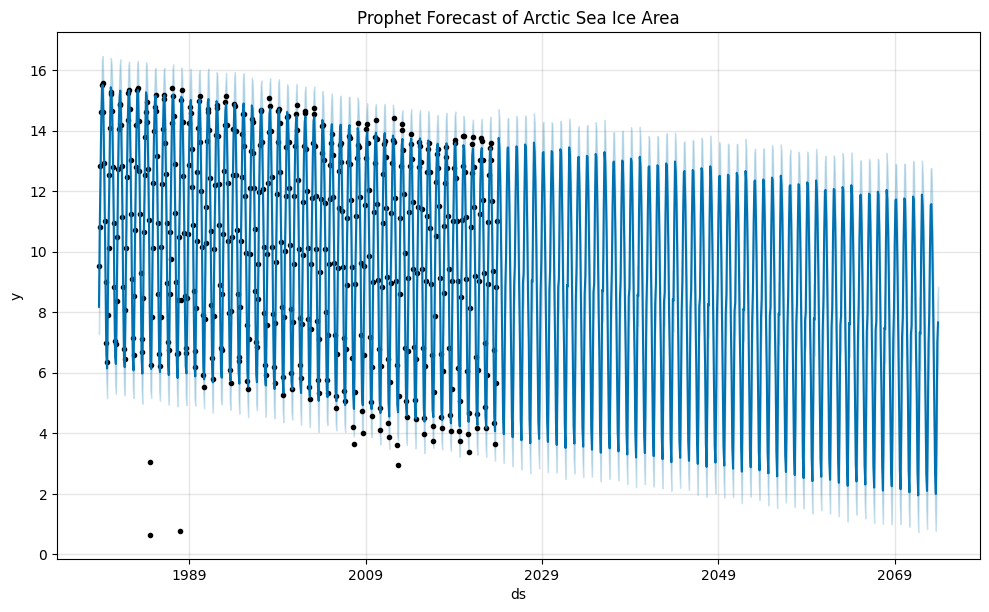


[Prophet] Average Sea Ice Area in 2024 (forecast): 9.267 million km²


In [13]:
from prophet import Prophet


# Prepare data for Prophet: must be DataFrame with columns ds (date) and y (target)
prophet_df = df[["date", "sia_million_km2"]].copy()
prophet_df["ds"] = prophet_df["date"].dt.to_timestamp()
prophet_df["y"] = prophet_df["sia_million_km2"]
prophet_df = prophet_df[["ds", "y"]]

# Initialize and fit model
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(prophet_df)

# Create future dataframe for forecasting 50 years monthly
future = m.make_future_dataframe(periods=n_years_forecast * 12, freq='M')

# Predict
forecast = m.predict(future)

# Extract relevant forecast
forecast_plot_df = forecast[["ds", "yhat"]].copy()
forecast_plot_df["year"] = forecast_plot_df["ds"].dt.year
forecast_plot_df["month"] = forecast_plot_df["ds"].dt.month

# Detect ice-free September
sep_forecast = forecast_plot_df[forecast_plot_df["month"] == 9]
ice_free = sep_forecast[sep_forecast["yhat"] < 1].head(1)

if not ice_free.empty:
    print(f"\n[Prophet] First ice-free September predicted in: {ice_free.iloc[0]['ds'].strftime('%Y-%m')}")
else:
    print("\n[Prophet] No ice-free September predicted within forecast horizon.")

# Plot
fig = m.plot(forecast)
plt.title("Prophet Forecast of Arctic Sea Ice Area")
plt.show()

# Filter 2024 forecasts
forecast_2024_prophet = forecast_plot_df[forecast_plot_df["year"] == 2024]

# Calculate average
avg_2024_prophet = forecast_2024_prophet["yhat"].mean()
print(f"\n[Prophet] Average Sea Ice Area in 2024 (forecast): {avg_2024_prophet:.3f} million km²")



Holt Winters

C:\Users\Sathvik\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



[Holt-Winters] First ice-free September predicted in: 2222-09


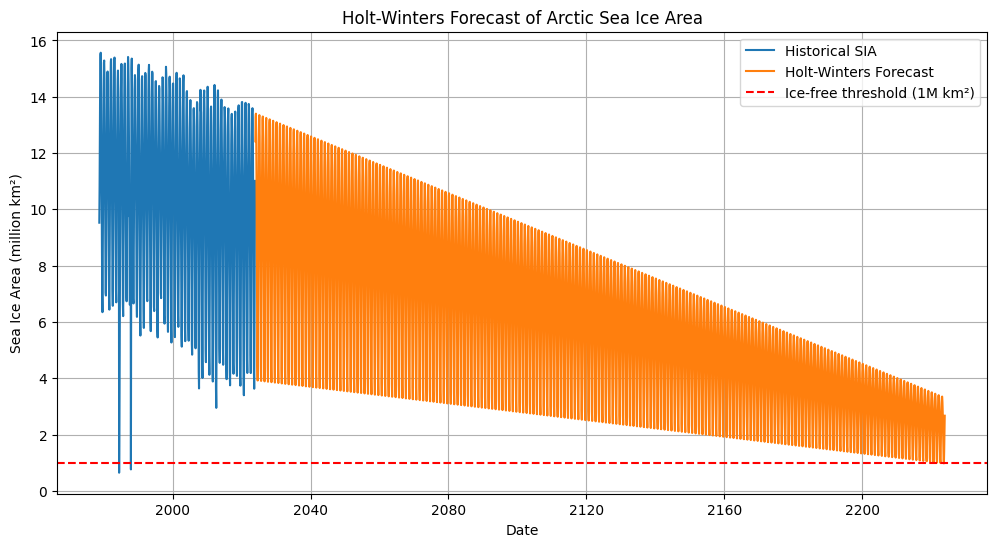


[Holt-Winters] Average Sea Ice Area in 2024 (forecast): 9.324 million km²


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Use the sea ice area time series indexed by date as timestamp
ts = pd.Series(y.values, index=df["date"].dt.to_timestamp())

# Fit Holt-Winters model with additive trend and multiplicative seasonality
hw_model = ExponentialSmoothing(ts, trend="add", seasonal="mul", seasonal_periods=12)
hw_fit = hw_model.fit()

# Forecast 50 years monthly
hw_forecast = hw_fit.forecast(n_years_forecast * 12)

# Detect ice-free September
hw_forecast_df = hw_forecast.to_frame(name="value").reset_index()
hw_forecast_df["year"] = hw_forecast_df["index"].dt.year
hw_forecast_df["month"] = hw_forecast_df["index"].dt.month

ice_free_hw = hw_forecast_df[(hw_forecast_df["month"] == 9) & (hw_forecast_df["value"] < 1)].head(1)
if not ice_free_hw.empty:
    print(f"\n[Holt-Winters] First ice-free September predicted in: {ice_free_hw.iloc[0]['index'].strftime('%Y-%m')}")
else:
    print("\n[Holt-Winters] No ice-free September predicted within forecast horizon.")

# Plot
plt.figure(figsize=(12,6))
plt.plot(ts.index, ts.values, label="Historical SIA")
plt.plot(hw_forecast.index, hw_forecast.values, label="Holt-Winters Forecast")
plt.axhline(1, color="red", linestyle="--", label="Ice-free threshold (1M km²)")
plt.xlabel("Date")
plt.ylabel("Sea Ice Area (million km²)")
plt.title("Holt-Winters Forecast of Arctic Sea Ice Area")
plt.legend()
plt.grid(True)
plt.show()

# Filter 2024 forecasts
forecast_2024_hw = hw_forecast_df[hw_forecast_df["year"] == 2024]

# Calculate average
avg_2024_hw = forecast_2024_hw["value"].mean()
print(f"\n[Holt-Winters] Average Sea Ice Area in 2024 (forecast): {avg_2024_hw:.3f} million km²")
